# Importing libraries

In [101]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from math import sqrt
from scipy import stats
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
import pandas_datareader
import math
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
from prettytable import PrettyTable
import cvxpy as cvx
from sklearn.covariance import LedoitWolf
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import requests
import json
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses
from sklearn.svm import SVR
import statsmodels.api as sm
import scipy.optimize as opt
from scipy.cluster.hierarchy import linkage, cut_tree, dendrogram
from scipy.spatial.distance import squareform
from fredapi import Fred
import getFamaFrenchFactors as gff
import quantstats as qs
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from scipy.stats import norm, kurtosis, skew

# Describing initial values

In [102]:
#Total years of traing model
years_training=1
# Define the end date
fecha = "2021-01-01"
end=fecha
# Convert the end date string to a datetime object
end_date = datetime.strptime(end, "%Y-%m-%d")
# Calculate the start date as one year before the end date
start_date = end_date - timedelta(days=365*years_training)
# Convert the start date to a string in the same format as the end date
start = start_date.strftime("%Y-%m-%d")

print("Start Date:", start)
print("End Date:", end)

Start Date: 2020-01-02
End Date: 2021-01-01


In [103]:
# Calculate the number of year form the date to today
def years_difference_from_today(date):
    # Convert the input date string to a datetime object
    date_object = datetime.strptime(date, '%Y-%m-%d')

    # Get today's date
    today = datetime.now()

    # Calculate the difference in years
    years_difference = today.year - date_object.year

    # Calculate the fraction of the current year
    fraction_of_year = (today - datetime(today.year, date_object.month, date_object.day)).days / 365

    # Check if the current month and day are before the input date's month and day
    if (today.month, today.day) < (date_object.month, date_object.day):
        years_difference -= 1

    # Add the fraction of the current year
    years_difference += fraction_of_year

    return years_difference

In [104]:
#Number of periods to change the portfolio allocation

years= years_difference_from_today(fecha)

# number of months
months = 2
periods = int(12* years / months)
leng_period= 30 * months


In [105]:
## define the stocks for our portfolio (via tickers) ###
assets = [ #Healthcare
          "JNJ", #(Johnson & Johnson)
          "PFE", #(Pfizer Inc.)
          "MRK", #(Merck & Co. Inc.)
          "LLY", #(Eli Lilly and company)
          "UNH", #(UnitedHealth Group Incorporated)
          "AMGN", #(Amgen Inc.)
          #Technology
          "MSFT", #(Microsoft Corporation)
          "GOOGL", #(Alphabet Inc. - Google)
          "META", #(Meta Platforms Inc. - Facebook)
          "NVDA", #(Nvidia)
          "AMD", #(Advanced micro devices)
          "TSLA", #(Tesla, Inc.)
          "CRM", #(Salesforce.com Inc.)
          # Finance
          "JPM", #(JPMorgan Chase & Co.)
          "MA", #(Mastercard)
          "BX", #(Blackstone)
          "AXP", #(American Express)
          "GS", #(The Goldman Sachs Group, Inc.)
          "BAC", #(Bank of America Corporation)
          "V", #(Visa Inc.)
          #Consumer goods
          "PG", #(Procter & Gamble Company)
          "KO", #(The Coca-Cola Company)
          "NKE", #(Nike, Inc.)
          "MCD", #(McDonald's Corporation)
          #Energy
          "XOM", #(Exxon Mobil Corporation)
          "CVX", #(Chevron Corporation)
          "SHEL", #(Royal Dutch Shell plc)
          "BP", #(BP p.l.c.)
          "COP", #(ConocoPhillips)
          #Retail
          "AMZN", #(Amazon.com, Inc.)
          "WMT", #(Walmart Inc.)
          "TGT", #(Target Corporation)
          "COST", #(Costco Wholesale Corporation)
          "HD", #(The Home Depot, Inc.)
          #Telecommunications
          "T", #(AT&T Inc.)
          "VZ", #(Verizon Communications Inc.)
          "TMUS", #(T-Mobile US, Inc.)
          #Utilities
          "NEE", #(NextEra Energy, Inc.)
          "DUK", #(Duke Energy Corporation)
          "SO", #(The Southern Company)
          "NRG", #(NRG Energy)
          "EXC", #(Exelon Corporation)
          "AEP", #(American Electric Power Company, Inc.)
          #Real Estate
          "SPG", #(Simon Property Group, Inc.)
          "AMT", #(American Tower Corporation)
          "EQIX", #(Equinix, Inc.)
          "PSA", #(Public Storage)
          "WELL", #(Welltower Inc.)
          #Transportation
          "UPS", #(United Parcel Service, Inc.)
          "FDX", #(FedEx Corporation)
          "DAL", #(Delta Air Lines, Inc.)
          "AAL", #(American Airlines Group Inc.)
          "BLDR", #(Builders first source)
          #"UBER", #(Uber Technologies, Inc.)                  No data before may 2018
          #"ROAD", #(Construction Partners, Inc)               No data before may 2018
          #cripto
          "BTC-USD", #Bitcoin
          "ETH-USD" #Ethereum
          ]

assets =sorted(assets)

## Micro and macroeconomic factors

### FRED

In [106]:
# Initialize Fred with your API key
api_key = '95c774645924b13f93458e248a922d67'
fred = Fred(api_key=api_key)
# Fetch GDP data (quarterly)
gdp = fred.get_series('GDP')

# Fetch Inflation (Consumer Price Index for All Urban Consumers)
inflation = fred.get_series('CPIAUCSL')

# Fetch Unemployment rate (monthly)
unemployment = fred.get_series('UNRATE')

# Fetch Federal Funds Rate (interest rate, monthly)
interest_rates = fred.get_series('FEDFUNDS')

# Combine the data into a DataFrame
macroeconomic_data = pd.concat([gdp, inflation, unemployment, interest_rates], axis=1)
macroeconomic_data.columns = ['GDP', 'Inflation', 'Unemployment', 'Interest Rates']

# Industrial Production Index (a proxy for industry-specific data)
industrial_production = fred.get_series('INDPRO')

# Average Hourly Earnings of All Employees, Total Private
hourly_earnings = fred.get_series('CES0500000003')

# Housing starts (a measure of consumer sentiment in the housing market)
housing_starts = fred.get_series('HOUST')

# Combine with other microeconomic data
microeconomic_data = pd.concat([industrial_production, hourly_earnings, housing_starts], axis=1)
microeconomic_data.columns = ['Industrial Production','Average Hourly Earnings',  'Housing Starts']

In [107]:
# Combine macro and microeconomic data
combined_data = pd.concat([macroeconomic_data, microeconomic_data], axis=1)

# Align the data to a common frequency (e.g., monthly)
combined_data = combined_data.resample('M').ffill()  # Forward-fill to avoid NaN gaps

#Get data only from the start date
combined_data= combined_data[combined_data.index > start]


In [108]:
# Resample to daily frequency
macro_daily = combined_data.resample('D').asfreq()

# Forward-fill NaN values for daily frequency
macro_daily.fillna(method='ffill', inplace=True)

#### Daily data

In [109]:
# U.S. Dollars to Euro Spot Exchange Rate daily
dollar_euro = fred.get_series('DEXUSEU')

# Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis
ten_Y = fred.get_series('DEXUSEU')

# Dow Jones Industrial Average
Dow = fred.get_series('DJIA')

# S&P 500
sp500 = fred.get_series('SP500')

# NASDAQ Composite Index
nasdaq = fred.get_series('NASDAQCOM')

# CBOE Gold ETF Volatility Index
gold = fred.get_series('GVZCLS')

# CBOE Crude Oil ETF Volatility Index
oil = fred.get_series('OVXCLS')

# CBOE Russell 2000 Volatility Index
russell = fred.get_series('RVXCLS')

# Combine daily data
daily_data = pd.concat([dollar_euro, ten_Y, Dow, nasdaq, gold, oil, russell], axis=1)
daily_data.columns = ['U.S. Dollars to Euro', 'Treasury Securities at 10-Year', 'Dow Jones', 'NASDAQ', 'Gold', 'Crude oil', 'Russell 2000']
#Get data only from the start date
daily_data= daily_data[daily_data.index > start]

In [110]:
# Combine macro and daily data
macro= pd.concat([macro_daily, daily_data], axis=1).dropna()
macro

,GDP,Inflation,Unemployment,Interest Rates,Industrial Production,Average Hourly Earnings,Housing Starts,U.S. Dollars to Euro,Treasury Securities at 10-Year,Dow Jones,NASDAQ,Gold,Crude oil,Russell 2000
2020-01-31,21706.513,258.906,3.6,1.55,101.3768,28.44,1578.0,1.1082,1.1082,28256.03,9150.94,13.50,40.35,20.33
2020-02-03,21706.513,258.906,3.6,1.55,101.3768,28.44,1578.0,1.1062,1.1062,28399.81,9273.40,12.48,41.81,19.78
2020-02-04,21706.513,258.906,3.6,1.55,101.3768,28.44,1578.0,1.1043,1.1043,28807.63,9467.97,12.01,39.44,17.54
2020-02-05,21706.513,258.906,3.6,1.55,101.3768,28.44,1578.0,1.1006,1.1006,29290.85,9508.68,11.32,37.88,16.41
2020-02-06,21706.513,258.906,3.6,1.55,101.3768,28.44,1578.0,1.0979,1.0979,29379.77,9572.15,11.45,36.44,16.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-24,28284.498,312.230,3.8,5.33,102.7562,34.68,1287.0,1.0687,1.0687,38460.92,15712.75,17.45,29.04,22.34
2024-04-25,28284.498,312.230,3.8,5.33,102.7562,34.68,1287.0,1.0721,1.0721,38085.80,15611.76,17.32,28.34,22.16
2024-04-26,28284.498,312.230,3.8,5.33,102.7562,34.68,1287.0,1.0686,1.0686,38239.66,15927.90,16.92,27.81,21.04
2024-04-29,28284.498,312.230,3.8,5.33,102.7562,34.68,1287.0,1.0717,1.0717,38386.09,15983.08,16.92,27.84,20.63


### EIA api

In [111]:
api_url = 'https://api.eia.gov/v2/steo/data'

params = {"api_key": "whsAp9dwvJg3dXf6Dx1y4BlbFji8hzZExBuZaL4g"}

header = {
    "frequency": "monthly",
    "data": [
        "value"
    ],
    "facets": {
        "seriesId": [
            "COPR_OPEC", #Global crude oil production
            "PAPR_WORLD",
            'BREPUSS',
            'COPR_OPEC',
            'D2TCPUS',
            'PASXPUS',
            'RAIMUUS',
            'T3_STCHANGE_US'
        ]
    },
    "start": start,
    "end": "2024-04",
    "sort": [
        {
            "column": "period",
            "direction": "desc"
        }
    ],
    "offset": 0,
    "length": 5000
}

r = requests.get(api_url, params=params, headers={"X-Params": json.dumps(header)})

In [112]:
# Transform data to a dataframe
file = r.json()
eia=pd.DataFrame(file['response']['data'])
# Set the date as a index
eia['period']=pd.to_datetime(eia['period'])
eia.set_index('period', inplace=True)
# Transform the data to have all the macroeconomic data in columns
eai_macro = eia.pivot_table(index='period', columns='seriesId', values='value', aggfunc='first')

In [113]:
# Resample to daily frequency
eai_daily = eai_macro.resample('D').asfreq()

# Forward-fill NaN values for daily frequency
eai_daily.fillna(method='ffill', inplace=True)
eai_daily

seriesId,COPR_OPEC,PAPR_WORLD,PASXPUS,RAIMUUS,T3_STCHANGE_US
period,,,,,
2020-01-01,27.32,101.00411098,1299.893185,53.87,-.58108270968
2020-01-02,27.32,101.00411098,1299.893185,53.87,-.58108270968
2020-01-03,27.32,101.00411098,1299.893185,53.87,-.58108270968
2020-01-04,27.32,101.00411098,1299.893185,53.87,-.58108270968
2020-01-05,27.32,101.00411098,1299.893185,53.87,-.58108270968
...,...,...,...,...,...
2024-03-28,26.895,102.53086846,1212.4401753,78.53,.20367834654
2024-03-29,26.895,102.53086846,1212.4401753,78.53,.20367834654
2024-03-30,26.895,102.53086846,1212.4401753,78.53,.20367834654


# Machine Learning expected returns

## Random Forest

In [114]:
#In this fuction the df_prices will have the
def RF(df):
  #Choose only the assets as output
  returns= df[assets]
  returns = returns.pct_change(periods=leng_period).shift(-leng_period)
  # Split into training and test sets (without using `train_test_split`)
  # For training and testing we are using the data leng_periods before because the target will be the mean return of the leng_periods later
  train_size = int(0.9 * (len(df)-leng_period))  # Example 80% train, 20% test
  #Using all the micro macro and asset as input
  X_train = df.iloc[:train_size]
  X_test = df.iloc[train_size:(len(df)-leng_period)]
  #using only assets return as output
  y_train = returns[:train_size]
  y_test = returns[train_size:(len(df)-leng_period)]
  # Standardize features for training and test
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  X_scaled = scaler.transform(df)
  best_params= {'bootstrap': False, 'max_depth': 26, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 910}
  # Train a Random Forest model
  model = RandomForestRegressor(**best_params, random_state=42)
  model.fit(X_train_scaled, y_train)

  # Predict on the test set
  y_pred = model.predict(X_test_scaled)

  # Evaluate with Mean Squared Error
  mse = mean_squared_error(y_test, y_pred)

  print("Mean Squared Error:", mse)
  prediction = model.predict(X_scaled)
  prediction = prediction[-leng_period:].mean(axis=0)
  return prediction

## XGBoost

In [115]:
#In this fuction the df_prices will have the
def XG(df):
  #Choose only the assets as output
  returns= df[assets]
  returns = returns.pct_change(periods=leng_period).shift(-leng_period)
  # Split into training and test sets (without using `train_test_split`)
  # For training and testing we are using the data leng_periods before because the target will be the mean return of the leng_periods later
  train_size = int(0.9 * (len(df)-leng_period))  # Example 80% train, 20% test
  #Using all the micro macro and asset as input
  X_train = df.iloc[:train_size]
  X_test = df.iloc[train_size:(len(df)-leng_period)]
  #using only assets return as output
  y_train = returns[:train_size]
  y_test = returns[train_size:(len(df)-leng_period)]
  # Standardize features for training and test
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  X_scaled = scaler.transform(df)
  best_params = {'colsample_bytree': 0.8659851446851979, 
                 'gamma': 0.013808385936852352, 
                 'learning_rate': 0.06788648955075587, 
                 'max_depth': 6, 
                 'min_child_weight': 3, 
                 'n_estimators': 441, 
                 'reg_alpha': 0.32815266747473193, 
                 'reg_lambda': 0.1550416167277442, 
                 'subsample': 0.8945522664931593}
  # Train a XGBoost using squarederror as objetive function
  model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, **best_params )
  model.fit(X_train_scaled, y_train)

  # Predict on the test set
  y_pred = model.predict(X_test_scaled)

  # Evaluate with Mean Squared Error
  mse = mean_squared_error(y_test, y_pred)

  print("Mean Squared Error:", mse)
  prediction = model.predict(X_scaled)
  prediction = prediction[-leng_period:].mean(axis=0)
  return prediction

## Neural Networks

In [116]:
def NN(df):
  #Choose only the assets as output
  returns= df[assets]
  returns = returns.pct_change(periods=leng_period).shift(-leng_period)
  # Split into training and test sets (without using `train_test_split`)
  # For training and testing we are using the data leng_periods before because the target will be the mean return of the leng_periods later
  train_size = int(0.9 * (len(df)-leng_period))  # Example 80% train, 20% test
  #Using all the micro macro and asset as input
  X_train = df.iloc[:train_size]
  X_test = df.iloc[train_size:(len(df)-leng_period)]
  #using only assets return as output
  y_train = returns[:train_size]
  y_test = returns[train_size:(len(df)-leng_period)]
  # Standardize features for training and test
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  X_scaled = scaler.transform(df)

  # Train a neural network
  model = keras.Sequential([
      layers.InputLayer(input_shape=(df.shape[1],)),  # Input layer
      layers.Dense(64, activation='relu'),  # First hidden layer with 64 neurons
      layers.Dropout(0.2),  # Dropout with rate of 0.2
      layers.Dense(64, activation='relu'),  # Second hidden layer with 64 neurons
      layers.Dropout(0.2),  # Dropout with rate of 0.2
      layers.Dense(len(assets))  # Output layer for predicting return prices
  ])

  # Compile the model with a low learning rate
  model.compile(
      optimizer=optimizers.Adam(learning_rate=1e-05),  # Learning rate of 1e-05
      loss=losses.MeanSquaredError(),  # Mean Squared Error for loss function
      metrics=['mae']  # Mean Absolute Error as a metric
  )
  # Train the model (using some validation data for evaluation)
  model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2)  # 20% data for validation


  # Predict on the test set
  y_pred = model.predict(X_test_scaled)

  # Evaluate with Mean Squared Error
  mse = mean_squared_error(y_test, y_pred)

  print("Mean Squared Error:", mse)
  prediction = model.predict(X_scaled)
  prediction = prediction[-leng_period:].mean(axis=0)
  return prediction

## Support Vector Machines (SVM)

In [117]:
# In this fuction the df_prices will have the
def SV(df):
  #Choose only the assets as output
  returns= df[assets]
  returns = returns.pct_change(periods=leng_period).shift(-leng_period)
  # Split into training and test sets (without using `train_test_split`)
  # For training and testing we are using the data leng_periods before because the target will be the mean return of the leng_periods later
  train_size = int(0.9 * (len(df)-leng_period))  # Example 80% train, 20% test
  #Using all the micro macro and asset as input
  X_train = df.iloc[:train_size]
  X_test = df.iloc[train_size:(len(df)-leng_period)]
  #using only assets return as output
  y_train = returns[:train_size]
  y_test = returns[train_size:(len(df)-leng_period)]
  # Standardize features for training and test
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  X_scaled = scaler.transform(df)

  # Dictionary to store the results of multiple SVR models
  predictions = {}
  mse =  {}
  # Train an SVR model for each asset column
  for asset in assets:
      y_train = returns[asset][:train_size]
      y_test = returns[asset][train_size:(len(df) - leng_period)]

      best_params= {'C': 100, 'gamma': 'scale', 'kernel': 'poly'}
      model = SVR(kernel='rbf', C=100, epsilon=0.1)  

      model.fit(X_train_scaled, y_train)  # Fit the model

      # Predict on the test set
      y_pred = model.predict(X_test_scaled)

      # Evaluate with Mean Squared Error for each model
      mse[asset] = mean_squared_error(y_test, y_pred)


      # Prediction on full data
      asset_prediction = model.predict(X_scaled)
      predictions[asset] = asset_prediction[-leng_period:].mean(axis=0)

  #print(f"Mean Squared Error ", mse)
  predictions = pd.Series(predictions)
  mse = sum(mse.values()) / len(mse)
  return predictions

# Calculation weights portfolio

## Markowitz using CVXPY

In [118]:
# Initial weight calculation using markowitz algorithm
def initial_weight(df_prices):
    # We transform the data to its logarithmic returns
    df = np.log(df_prices).diff()
    # Drop the first row because we loose information for the logarithmic return.
    df = df.dropna()  # this is a dataframe

    # Compute the Expected Returns, we multiply daily return by 252
    #because there are 252 business days in the US.
    exp_returns = df.mean()*252
    # compute the covariance matrix
    cova = df.cov()*252
    #number of assets
    m=exp_returns.shape[0]
    # WANT: optimal portfolio with the following constraints
    # 1. no short sales are allowed  that is the weights for all stocks are >=0
    # 2. Maximum value of 15%
    # 3. Minimum value of 5%
    # 4. The asset could take the minimun value or Zero

    #def optimize_portfolio(exp_returns, index_weights, scale=.0000):
    cov_real = np.array(cova)   # variance-covariance matrix of assets
    X = np.random.multivariate_normal(mean=np.zeros(len(assets)),  #get multivariable normal distribution using mean zero
                                      cov=cov_real,
                                      size=len(assets))
    cov = LedoitWolf().fit(X) # calculation covariance using shrinkage method of ledoit
    Q=cov.covariance_
    q = np.array(exp_returns) # q is the exptected returns of assets

    #  Constraints

    h =np.ones(m)*0.02  # Minimum value
    k=np.zeros(m)       # For values zero
    j =np.ones(m)*0.15   # Maximum value

    # Define and solve the quadratic problem using CVXPY:
    # ===================================================
    x = cvx.Variable(m)
    turnover=0.20
    k=0.01 # % fixed cost

    objective=cvx.Maximize((-1/2)*cvx.quad_form(x, Q) + q.T @ x)


    constraints=[x >= cvx.multiply(k, h), # Give a minimum value and also posivility of choose 0
                  x <= j, # Maximum value
                  x >= 0,
                  cvx.sum(x) == 1] # Constrain sum 1

    prob = cvx.Problem(objective,constraints)

    prob.solve()
    #retrieve the weights of the optimized portfolio
    x_values = x.value

    # Eliminate the small numbers
    threshold = 1e-10
    weights=np.where(np.abs(x_values) < threshold, 0, x_values)

    return weights

In [119]:
#Markowitz algorithm using the initial weight to calculate the cost contraint due to the change in the asset
def markowitz(df_prices, initial_weight, expected_returns):
    # We transform the data to its logarithmic returns
    df = np.log(df_prices).diff()
    # Drop the first row because we loose information for the logarithmic return.
    df = df.dropna()  # this is a dataframe

    # Compute the Expected Returns, we multiply daily return by 252
    #because there are 252 business days in the US.
    #exp_returns = df.mean()*252

    #Calculate expected returns using the input
    exp_returns = expected_returns*252
    # compute the covariance matrix
    cova = df.cov()*252
    #number of assets
    m=exp_returns.shape[0]
    # WANT: optimal portfolio with the following constraints
    # 1. no short sales are allowed  that is the weights for all stocks are >=0
    # 2. Maximum value of 15%
    # 3. Minimum value of 5%
    # 4. The asset could take the minimun value or Zero

    #def optimize_portfolio(exp_returns, index_weights, scale=.0000):
    cov_real = np.array(cova)   # variance-covariance matrix of assets
    X = np.random.multivariate_normal(mean=np.zeros(len(assets)),  #get multivariable normal distribution using mean zero
                                      cov=cov_real,
                                      size=len(assets))
    cov = LedoitWolf().fit(X) # calculation covariance using shrinkage method of ledoit
    Q=cov.covariance_
    q = np.array(exp_returns) # q is the exptected returns of assets

    #  Constraints

    h =np.ones(m)*0.02  # Minimum value
    k=np.zeros(m)       # For values zero
    j =np.ones(m)*0.15   # Maximum value

    # Define and solve the quadratic problem using CVXPY:
    # ===================================================
    x = cvx.Variable(m)

    turnover=0.20
    k=0.01 # % fixed cost

    cost = k * cvx.norm(x-initial_weight, 1) # transaction cost

    objective=cvx.Maximize((-1/2)*cvx.quad_form(x, Q) + q.T @ x - cost)


    constraints=[#x >= cvx.multiply(k, h), # Give a minimum value and also posivility of choose 0
                  x <= j, # Maximum value
                  #cvx.abs(x-initial_weight) <= turnover, #turnover constraint
                  x >= 0,
                  cvx.sum(x) == 1]

    prob = cvx.Problem(objective,constraints)

    prob.solve()
    #retrieve the weights of the optimized portfolio
    x_values = x.value

    # Eliminate the small numbers
    threshold = 1e-10
    weights=np.where(np.abs(x_values) < threshold, 0, x_values)

    return weights


## Markowitz using Scipy as optimizer

In [120]:
# Portfolio optimization function
def initial_weight_scipy(df_prices, min_assets=7, penalty_factor=10):
    df = np.log(df_prices).diff().dropna()
    # Calculation of exp returns using random forest
    exp_returns = RF(df_prices) * 252
    cov_matrix = df.cov() * 252

    m = len(exp_returns)

    # Objective function with a penalty if fewer than 20 assets are selected
    def objective(x):
        risk = 0.5 * (x @ cov_matrix @ x)
        expected_return = exp_returns @ x
        # Count how many assets are greater than a small threshold (e.g., 0.01)
        non_zero_count = np.sum(x > 0.005)
        # Penalty for fewer than the minimum required assets
        penalty = penalty_factor * max(0, min_assets - non_zero_count)
        return risk - expected_return + penalty  # Minimize risk, maximize return, with penalty

    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Portfolio must sum to 100%
    ]

    # Bounds for asset weights (0.01 is the lower bound to consider an asset non-zero)
    bounds = [(0.0, 0.15) for _ in range(m)]  # Weight bounds (1% to 15%)

    # Initial guess (equal distribution)
    initial_guess = np.full(m, 1/m)

    # Solver options
    options = {
        'ftol': 1e-6,  # Convergence tolerance
        'maxiter': 1000,  # Maximum iterations
    }

    # Optimization using SLSQP
    result = opt.minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints, options=options)

    if not result.success:
        raise Exception("Optimization failed:", result.message)

    # Eliminate the small numbers
    threshold = 1e-10
    weights=np.where(np.abs(result.x) < threshold, 0, result.x)

    return weights  # Optimized weights



In [121]:
# Portfolio optimization function
def weight_scipy(df_prices, initial_weight, expected_returns, min_assets=7, penalty_factor=10, transaction_cost=0.01, turnover_limit=0.20):
    df = np.log(df_prices).diff().dropna()
    # Calculation of exp returns using random forest
    exp_returns = expected_returns * 252
    cov_matrix = df.cov() * 252

    m = len(exp_returns)

    # Objective function with a penalty if fewer than 20 assets are selected
    def objective(x):
        risk = 0.5 * (x @ cov_matrix @ x)
        expected_return = exp_returns @ x
        # Count how many assets are greater than a small threshold (e.g., 0.01)
        non_zero_count = np.sum(x > 0.005)
        # Penalty for fewer than the minimum required assets
        penalty = penalty_factor * max(0, min_assets - non_zero_count)
        # Transaction cost based on absolute weight changes from initial weights
        cost = transaction_cost * np.sum(np.abs(x - initial_weight))
        return risk - expected_return + penalty + cost  # Minimize risk, maximize return, with penalty

    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Portfolio must sum to 100%
        #{'type': 'ineq', 'fun': lambda x: turnover_limit - np.sum(np.abs(x - initial_weight))},  # Turnover limit
    ]

    # Bounds for asset weights (0.01 is the lower bound to consider an asset non-zero)
    bounds = [(0.0, 0.15) for _ in range(m)]  # Weight bounds (1% to 15%)

    # Initial guess (equal distribution)
    initial_guess = initial_weight

    # Solver options
    options = {
        'ftol': 1e-6,  # Convergence tolerance
        'maxiter': 5000,  # Maximum iterations
    }

    # Optimization using SLSQP
    result = opt.minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints, options=options)

    if not result.success:
        raise Exception("Optimization failed:", result.message)

    # Eliminate the small numbers
    threshold = 1e-10
    weights=np.where(np.abs(result.x) < threshold, 0, result.x)

    return weights  # Optimized weights


## HRP algorithm

In [122]:
#Using code of Marcos lopex del pradro <lopezdeprado@lbl.gov>
# Hierarchical Risk Parity
# Allocate portfolio weights using Hierarchical Risk Parity
def preprocess_data(df_prices):
    df = np.log(df_prices).diff().dropna()  # Log returns
    #exp_returns = RF(df_prices) * 252  # Expected returns on annual basis using random forest
    exp_returns = df.mean()*252
    cov_matrix = df.cov() * 252  # Covariance matrix
    return exp_returns, cov_matrix

def hierarchical_clustering(cov_matrix):
    # Create a distance matrix from the correlation matrix
    corr_matrix = cov_matrix / (np.sqrt(np.diag(cov_matrix))[:, None] * np.sqrt(np.diag(cov_matrix))[None, :])
    distance_matrix = np.sqrt(0.5 * (1 - corr_matrix))

    # Convert to symmetric and set diagonal to zero
    distance_matrix_clean = distance_matrix.to_numpy()
    np.fill_diagonal(distance_matrix_clean, 0)

    # Hierarchical clustering using Ward's method
    linkage_matrix = linkage(squareform(distance_matrix_clean), method='ward')
    return linkage_matrix

def get_quasi_diag(linkage_matrix):
    # Sort clustered items by distance
    sort_ix = pd.Series([linkage_matrix[-1, 0], linkage_matrix[-1, 1]], dtype=int)
    num_items = linkage_matrix[-1, 3]  # Number of original items

    while sort_ix.max() >= num_items:
        # Adjust indices to make space
        sort_ix.index = range(0, len(sort_ix) * 2, 2)
        # Get the clusters greater than the number of items
        df0 = sort_ix[sort_ix >= num_items]
        # Integer conversion for indexing
        i = df0.index
        j = (df0.values.astype(int) - num_items).astype(int)
        # Re-assign values in sort_ix
        sort_ix[i] = linkage_matrix[j, 0].astype(int)
        # Create a new Series with new indices and sort
        df0 = pd.Series(linkage_matrix[j, 1].astype(int), index=i + 1)
        sort_ix = pd.concat([sort_ix, df0]).sort_index()
        sort_ix.index = range(len(sort_ix))  # Re-index
    return sort_ix.tolist()

def getIVP(cov,**kargs):
    # Compute the inverse-variance portfolio
    ivp=1./np.diag(cov)
    ivp/=ivp.sum()
    return ivp

def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def get_rec_bipart(cov_matrix, sorted_ix):
    # Compute HRP allocations recursively
    w = pd.Series(1, index=sorted_ix)  # Initialize all items with equal weights
    c_items = [sorted_ix]  # Initialize all items in one cluster
    # convert the index names as numbers
    custom_indices = list(range(len(cov_matrix)))
    cov_matrix.index = custom_indices
    cov_matrix.columns = custom_indices
    while len(c_items) > 0:
        c_items=[i[j:k] for i in c_items for j,k in ((0,len(i)//2), (len(i)//2,len(i))) if len(i)>1] # bi-section
        for i in range(0, len(c_items), 2):  # Parse in pairs
            c_items0 = c_items[i]  # Cluster 1
            c_items1 = c_items[i + 1]  # Cluster 2

            # Calculate the variance for each cluster
            c_var0=getClusterVar(cov_matrix,c_items0)
            c_var1=getClusterVar(cov_matrix,c_items1)
            # Allocate weights based on variance
            alpha = 1 - c_var0 / (c_var0 + c_var1)
            w[c_items0] *= alpha        # weight 1
            w[c_items1] *= (1 - alpha)  # weight 2
    return w

def weights_hrp(df_prices):
    exp_returns, cov_matrix = preprocess_data(df_prices)

    # Perform hierarchical clustering
    linkage_matrix = hierarchical_clustering(cov_matrix)

    # Get the quasi-diagonalized order
    sorted_ix = get_quasi_diag(linkage_matrix)
    # Perform recursive bisection to get weights
    hrp_weights = get_rec_bipart(cov_matrix, sorted_ix)
    sort_weights = hrp_weights.sort_index()
    sort_weights = sort_weights.tolist()
    return sort_weights

In [123]:
assets =sorted(assets)
# Acquire data
end_period = (datetime.strptime(end, "%Y-%m-%d") + timedelta(days=(periods+1)*leng_period)).strftime("%Y-%m-%d")
print(end_period)
df_prices = yf.download(assets,start=start,end=end_period)['Adj Close']
df_prices_all = df_prices.dropna()
market_prices_all = yf.download("^GSPC",start=start,end=end_period)['Adj Close']
print(start, end)
#Initial weight using CVXPY
#initial_weight = initial_weight(df_prices_all[start:end])
#Initial weight using spicy
initial_weight = initial_weight_scipy(df_prices_all[start:end])
ini_weight = initial_weight
print(initial_weight)

2024-06-14


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2020-01-02 2021-01-01
Mean Squared Error: 0.020835548661813034
[4.61750492e-10 0.00000000e+00 0.00000000e+00 3.70961064e-10
 3.70293057e-10 1.31193709e-10 0.00000000e+00 1.30509725e-10
 9.99999997e-02 5.91552623e-10 1.49999999e-01 0.00000000e+00
 1.82107624e-10 0.00000000e+00 0.00000000e+00 1.80412976e-10
 0.00000000e+00 0.00000000e+00 2.93163674e-10 1.49999999e-01
 0.00000000e+00 1.49999999e-01 0.00000000e+00 0.00000000e+00
 1.99935197e-10 2.61361596e-10 0.00000000e+00 1.25613263e-10
 2.37856821e-10 2.85436549e-10 1.70261100e-10 0.00000000e+00
 3.42500226e-10 1.59960004e-10 0.00000000e+00 1.50000000e-01
 3.47903914e-10 0.00000000e+00 0.00000000e+00 1.47333690e-10
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.76144390e-10 1.50000000e-01 0.00000000e+00 1.49999999e-01
 0.00000000e+00 0.00000000e+00 1.89824167e-10 1.48187247e-10
 1.65854889e-10 0.00000000e+00 4.28092221e-10]


If there is singularity problem like "LinAlgError: SVD did not converge" Check the values of the assets. Could have nan value because there not exist in yahoo

### Plot HRP initial weights

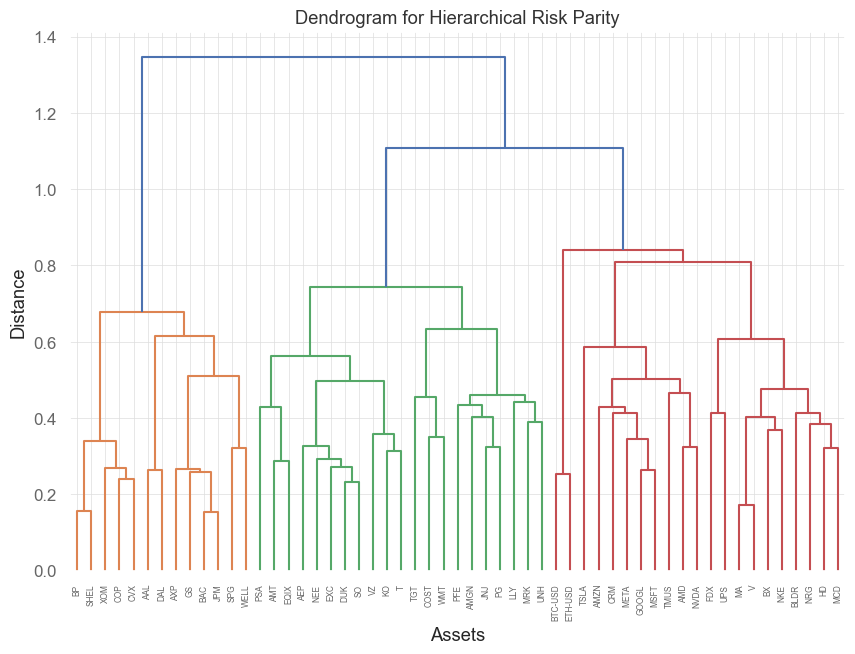

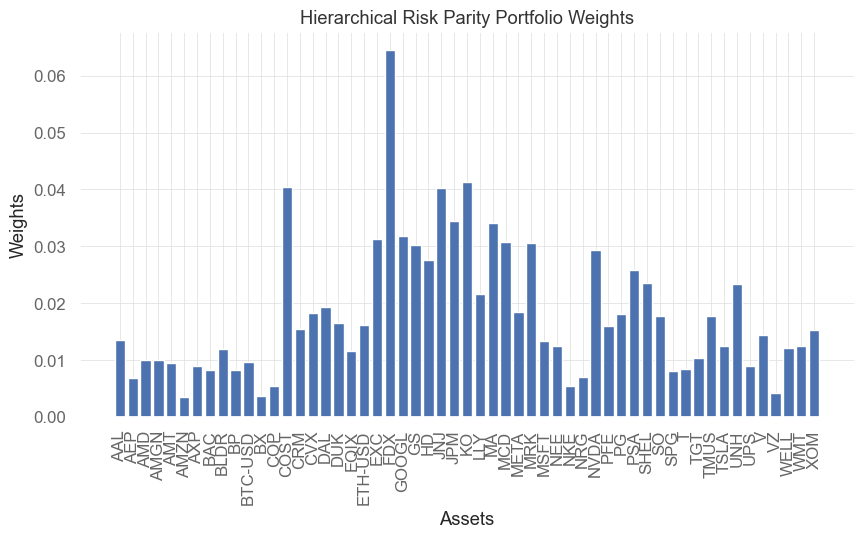

In [124]:
# Use your functions to get the linkage matrix and HRP weights
exp_returns, cov_matrix = preprocess_data(df_prices_all[start:end])
linkage_matrix = hierarchical_clustering(cov_matrix)
sorted_ix = get_quasi_diag(linkage_matrix)
hrp_weights = get_rec_bipart(cov_matrix, sorted_ix)

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=assets, leaf_rotation=90)
plt.title("Dendrogram for Hierarchical Risk Parity")
plt.xlabel("Assets")
plt.ylabel("Distance")
plt.show()

# Plot the HRP portfolio weights
plt.figure(figsize=(10, 5))
plt.bar(assets, hrp_weights)
plt.title("Hierarchical Risk Parity Portfolio Weights")
plt.xlabel("Assets")
plt.ylabel("Weights")
plt.xticks(rotation=90)  # Rotate x-axis labels to vertical position
plt.show()

## Calculate weights of all periods

In [125]:
# Join the micro and macroeconomic with all the asset to use it as input in the machine learning
macro_prices = df_prices_all.join(macro, how='inner')  # Join the Fred economic variable with the assets value
macro_prices = macro_prices.join(eai_daily, how='inner') # Join the EAI economic variable with the preview table

In [126]:
end=fecha
weights=[]
table = PrettyTable()
table.field_names = ["Start Date", "End Date"]
min_assets= 15
selected_assets = []
for i in range(periods):
  # Convert the end date string to a datetime object
  end_date = datetime.strptime(end, "%Y-%m-%d")
  # Calculate the start date as one year before the end date
  start_date = end_date - timedelta(days=365*years_training)
  # Convert the start date to a string in the same format as the end date
  start = start_date.strftime("%Y-%m-%d")
  end = end_date.strftime("%Y-%m-%d")
  print(start, end)
  table.add_row([start, end])
  #Call the prices from prices of all the asssets
  df_prices=df_prices_all[start:end]
  #Machine learning algorithm to calculate the expected returns
  ml_data=macro_prices[start:end]
  expected_returns = SV(ml_data)

  #weigt using CVXPY
  #weight=markowitz(df_prices, initial_weight, expected_returns)
  #weigt using spicy optimizer
  weight=weight_scipy(df_prices, initial_weight, expected_returns, min_assets=min_assets)
    
    
#weight using HRP
  # Get the indices of the top 15 assets with the highest expected returns
  #top_indices = np.argsort(expected_returns)[-min_assets:][::-1]  # Get top 15 indices in descending order
  # Get the names of the top assets
  #top_assets = [assets[i] for i in top_indices]
  #sort top_assets by name
  #top_assets = sorted(top_assets)
  #print(top_assets)
  #weight = weights_hrp(df_prices[top_assets])
  #print(weight)
  # Initialize dictionary to store combined assets and weights
  #combined_assets = {}
  # Iterate over all assets
  #for asset in assets:
        # Check if the asset is in the previous list
  #      if asset in top_assets:
            # If yes, get the corresponding weight
  #          t_weight = weight[top_assets.index(asset)]
  #      else:
            # If not, assign a weight of zero
  #          t_weight = 0.0
        # Add the asset and weight to the dictionary
  #      combined_assets[asset] = t_weight

  #print(combined_assets)
  # Append the weights for this period to the matrix
  #weights.append([pair[1] for pair in list(combined_assets.items())])
################
    
  weights.append(weight)
  end_date += timedelta(days=leng_period)
  end = end_date.strftime("%Y-%m-%d")
  initial_weight = weight
print(table)

2020-01-02 2021-01-01
2020-03-02 2021-03-02
2020-05-01 2021-05-01
2020-06-30 2021-06-30
2020-08-29 2021-08-29
2020-10-28 2021-10-28
2020-12-27 2021-12-27
2021-02-25 2022-02-25
2021-04-26 2022-04-26
2021-06-25 2022-06-25
2021-08-24 2022-08-24
2021-10-23 2022-10-23
2021-12-22 2022-12-22
2022-02-20 2023-02-20
2022-04-21 2023-04-21
2022-06-20 2023-06-20
2022-08-19 2023-08-19
2022-10-18 2023-10-18
2022-12-17 2023-12-17
2023-02-15 2024-02-15
+------------+------------+
| Start Date |  End Date  |
+------------+------------+
| 2020-01-02 | 2021-01-01 |
| 2020-03-02 | 2021-03-02 |
| 2020-05-01 | 2021-05-01 |
| 2020-06-30 | 2021-06-30 |
| 2020-08-29 | 2021-08-29 |
| 2020-10-28 | 2021-10-28 |
| 2020-12-27 | 2021-12-27 |
| 2021-02-25 | 2022-02-25 |
| 2021-04-26 | 2022-04-26 |
| 2021-06-25 | 2022-06-25 |
| 2021-08-24 | 2022-08-24 |
| 2021-10-23 | 2022-10-23 |
| 2021-12-22 | 2022-12-22 |
| 2022-02-20 | 2023-02-20 |
| 2022-04-21 | 2023-04-21 |
| 2022-06-20 | 2023-06-20 |
| 2022-08-19 | 2023-08-19 |


# Evaluation of portfolio

In [127]:
start= fecha
start_date = datetime.strptime(start, "%Y-%m-%d")
end_date = start_date + timedelta(days=leng_period*periods)
end = end_date.strftime("%Y-%m-%d")

print("Start Date:", start)
print("End Date:", end)

initial_market_prices = yf.download("^GSPC",start=start,end=end)['Adj Close']
initial_df_prices = yf.download(assets,start=start,end=end)['Adj Close']
initial_df_prices = initial_df_prices.dropna()

[*********************100%%**********************]  1 of 1 completed
[****                   9%%                      ]  5 of 55 completed

Start Date: 2021-01-01
End Date: 2024-04-15


[*********************100%%**********************]  55 of 55 completed


In [128]:
def count_differing_values(array1, array2, threshold):
    # Convert lists to numpy arrays
    array1 = np.array(array1)
    array2 = np.array(array2)

    # Calculate absolute difference between arrays
    diff = np.abs(array1 - array2)
    # Count differing values based on threshold
    differing_count = np.sum(diff > threshold)
    return differing_count

In [129]:
Total_invest=1_000
Total_invest_market=Total_invest
bl_portfolio = []
market=[]
portfolio=[]
hapi=[]
table = PrettyTable()
table.field_names = ["Start Date", "End Date"]
for x in range(periods):
    # Convert the start date string to a datetime object
    start_date = datetime.strptime(start, "%Y-%m-%d")+ timedelta(days=1)
    #sum leng period to the end date
    end_date = start_date + timedelta(days=leng_period)
    # Convert the end date to a string in the same format as the end date
    end = end_date.strftime("%Y-%m-%d")
    start= start_date.strftime("%Y-%m-%d")
    print(start, end)
    table.add_row([start, end])
    #Call the prices from market
    market_prices=market_prices_all[start:end]
    #Call the prices from prices of all the asssets
    df_prices = df_prices_all[start:end]

    portfolio= np.zeros(len(df_prices))
    # Loop through each asset and its weight, and calculate the contribution to the portfolio
    for i in range(len(assets)):
        asset_name = assets[i]
        #print(asset_name,df_prices[asset_name][0])
        asset_price = df_prices[asset_name]/df_prices[asset_name][0]
        asset_weight = weights[x][i]
        portfolio += asset_price * asset_weight
    portf = portfolio*Total_invest

    # Recalculation of the new total invest by the end of the period
    cost = 0.15 # price for buying or sell a faction of a share (hapi)
    if x==0:
        transactions=count_differing_values(weights[x], ini_weight, 1e-3)
    else:
        transactions = count_differing_values(weights[x], weights[x-1], 1e-3)
    total_cost = transactions*cost
    hapi.append(total_cost)
    Total_invest=portfolio[-1]*Total_invest-total_cost
    bl_portfolio.append(portf)
    market_prices=market_prices/initial_market_prices[0]*Total_invest_market
    market.append(market_prices)
    start_date += timedelta(days=leng_period)
    start= start_date.strftime("%Y-%m-%d")
print(table)

2021-01-02 2021-03-03
2021-03-04 2021-05-03
2021-05-04 2021-07-03
2021-07-04 2021-09-02
2021-09-03 2021-11-02
2021-11-03 2022-01-02
2022-01-03 2022-03-04
2022-03-05 2022-05-04
2022-05-05 2022-07-04
2022-07-05 2022-09-03
2022-09-04 2022-11-03
2022-11-04 2023-01-03
2023-01-04 2023-03-05
2023-03-06 2023-05-05
2023-05-06 2023-07-05
2023-07-06 2023-09-04
2023-09-05 2023-11-04
2023-11-05 2024-01-04
2024-01-05 2024-03-05
2024-03-06 2024-05-05
+------------+------------+
| Start Date |  End Date  |
+------------+------------+
| 2021-01-02 | 2021-03-03 |
| 2021-03-04 | 2021-05-03 |
| 2021-05-04 | 2021-07-03 |
| 2021-07-04 | 2021-09-02 |
| 2021-09-03 | 2021-11-02 |
| 2021-11-03 | 2022-01-02 |
| 2022-01-03 | 2022-03-04 |
| 2022-03-05 | 2022-05-04 |
| 2022-05-05 | 2022-07-04 |
| 2022-07-05 | 2022-09-03 |
| 2022-09-04 | 2022-11-03 |
| 2022-11-04 | 2023-01-03 |
| 2023-01-04 | 2023-03-05 |
| 2023-03-06 | 2023-05-05 |
| 2023-05-06 | 2023-07-05 |
| 2023-07-06 | 2023-09-04 |
| 2023-09-05 | 2023-11-04 |


In [130]:
for i in range(periods):
    SP500_earnings = (market[i][-1]-market[i][0])/market[i][0]
    print("Earning % S&P500:", SP500_earnings*100)
    BL_earnings=(bl_portfolio[i][-1]-bl_portfolio[i][0])/bl_portfolio[i][0]
    print("Earning % Markowitz portfolio:", BL_earnings*100)

Earning % S&P500: 3.2175447962252295
Earning % Markowitz portfolio: 15.728343449002438
Earning % S&P500: 11.25629735262899
Earning % Markowitz portfolio: 30.40295410684965
Earning % S&P500: 4.506482653052623
Earning % Markowitz portfolio: -9.35910204551628
Earning % S&P500: 4.4528231468022845
Earning % Markowitz portfolio: 23.085362649486864
Earning % S&P500: 2.0994640612254174
Earning % Markowitz portfolio: 20.363378196008426
Earning % S&P500: 2.2660394661119123
Earning % Markowitz portfolio: -13.410906251108843
Earning % S&P500: -9.750528205485793
Earning % Markowitz portfolio: -10.477681339295202
Earning % S&P500: 2.3584374962226082
Earning % Markowitz portfolio: 2.898409911422975
Earning % S&P500: -7.753800576724483
Earning % Markowitz portfolio: -9.136337758308384
Earning % S&P500: 2.4239276030717036
Earning % Markowitz portfolio: 10.492565052125274
Earning % S&P500: -4.818088466815178
Earning % Markowitz portfolio: 12.344231750452158
Earning % S&P500: 1.4212739005189787
Earning %

## Total earnings

In [131]:
SP500_earnings = (market[-1][-1]-market[0][0])/market[0][0]
print("Earning % S&P500:", SP500_earnings*100)
BL_earnings=(bl_portfolio[-1][-1]-bl_portfolio[0][0])/bl_portfolio[0][0]
print("Earning % Markowitz portfolio:", BL_earnings*100)

Earning % S&P500: 38.56458120544966
Earning % Markowitz portfolio: 192.9847543648795


## Behavior of portfolio agains S&P500

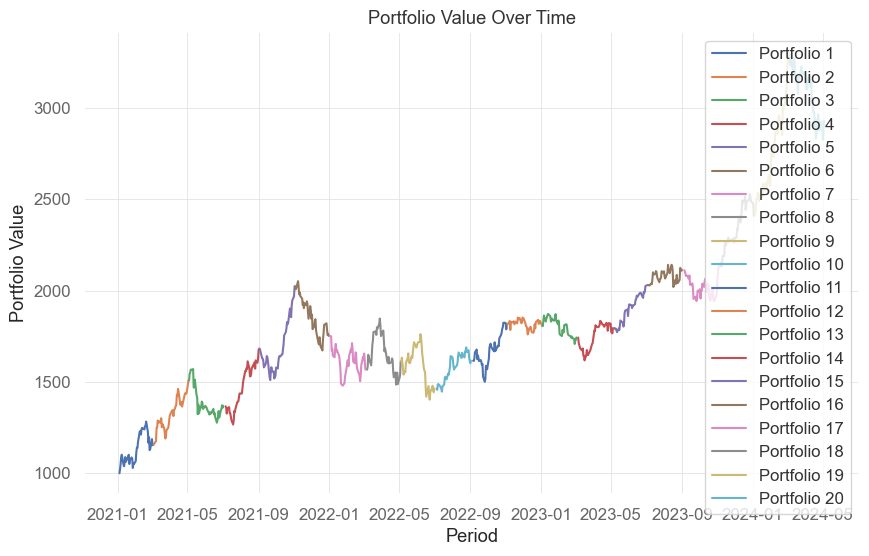

In [132]:
# Plot each array in bl_portfolio
for i, portfolio_values in enumerate(bl_portfolio):
    plt.plot(portfolio_values, label=f'Portfolio {i+1}')

plt.xlabel('Period')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

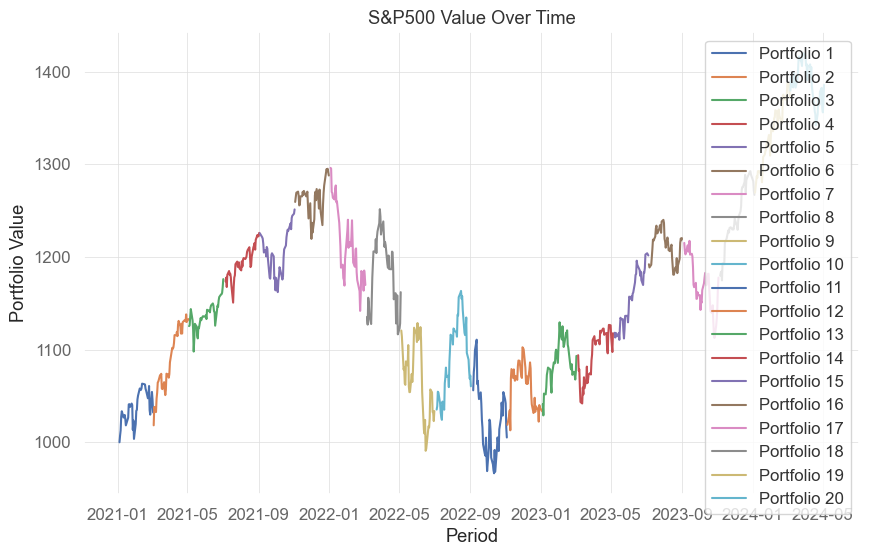

In [133]:
# Plot each array in bl_portfolio
for i, portfolio_values in enumerate(market):
    plt.plot(portfolio_values, label=f'Portfolio {i+1}')

plt.xlabel('Period')
plt.ylabel('Portfolio Value')
plt.title('S&P500 Value Over Time')
plt.legend()
plt.show()

In [134]:
#convert to a dataframe
df_portfolio=pd.DataFrame(bl_portfolio)
# Replace all the nan to value 0. When you do a dataframe it will create several row per each run and the columns are the dates
df_portfolio.fillna(0, inplace=True)

#transpose to have the date as row and all the run as columns
df_portfolio = df_portfolio.transpose()
#sum all the columns in the same row to have and unique value per row
df_portfolio = df_portfolio.sum(axis=1)

start= fecha
start_date = datetime.strptime(start, "%Y-%m-%d")
end_date = start_date + timedelta(days=leng_period*periods)
end = end_date.strftime("%Y-%m-%d")
sp500 = yf.download("^GSPC",start=start,end=end)['Adj Close']
market=sp500/sp500[0]*Total_invest_market

[*********************100%%**********************]  1 of 1 completed


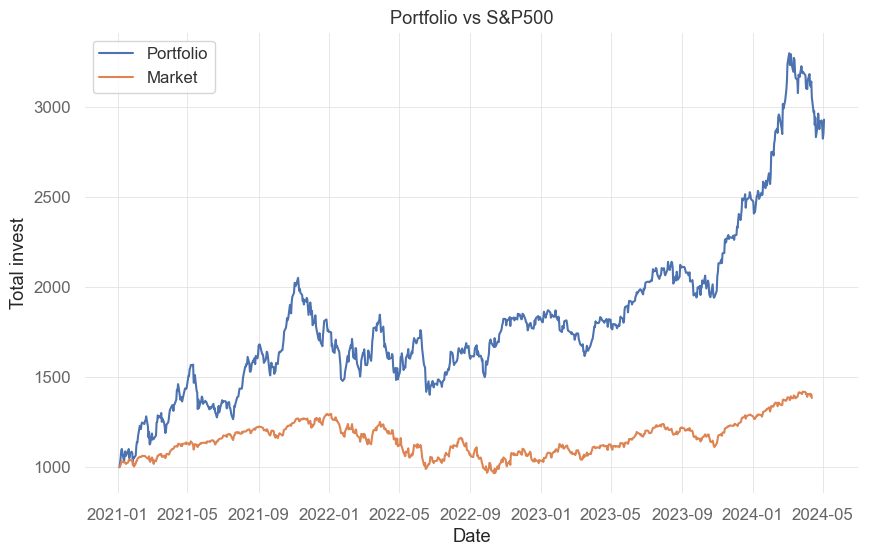

In [135]:
# Plot df_portfolio
plt.plot(df_portfolio.index, df_portfolio, label='Portfolio')
plt.xlabel('Date')
plt.ylabel('Total invest')
plt.title('Portfolio vs S&P500')

# Plot market
plt.plot(market.index, market, label='Market')

# Add legend
plt.legend()

# Show the plot
plt.show()

## Weight distribution for all periods

In [136]:
df=pd.DataFrame(weights, columns=assets)

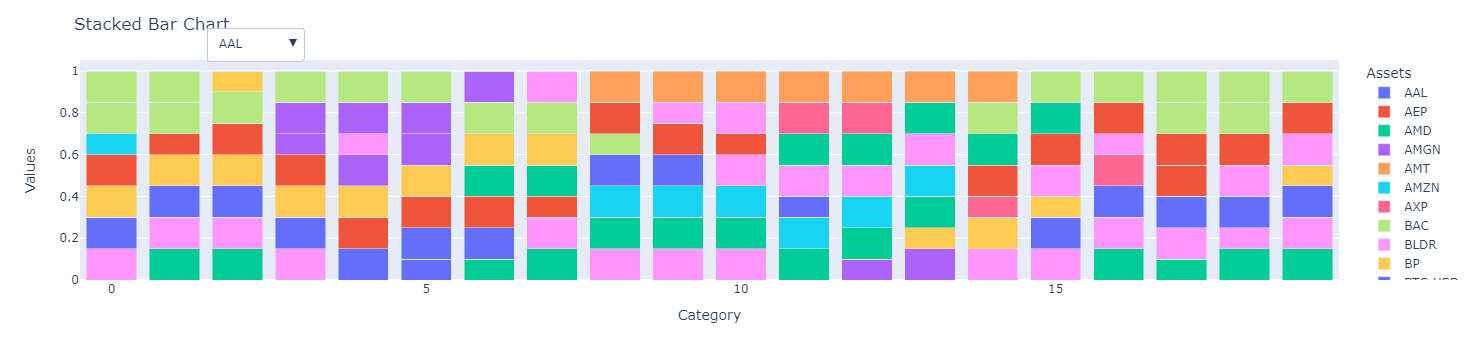

In [137]:
import plotly.express as px

# Assuming df is your DataFrame with data
fig = px.bar(df, barmode='stack')
fig.update_layout(
    title='Stacked Bar Chart',
    xaxis=dict(title='Category'),
    yaxis=dict(title='Values'),
    legend=dict(title='Assets'),
)
# Create dropdown menu for variable selection
buttons = [
    dict(label=var, method='update', args=[{'visible': [col == var for col in df.columns]}])
    for var in df.columns
]
# Add an option to reset the graph
buttons.append(
    dict(label="Reset", method="update", args=[{'visible': [True] * len(df.columns)}])
)

fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction='down',
            showactive=True,
            x=0.1,
            xanchor='left',
            y=1.15,
            yanchor='top'
        ),
    ]
)
fig.show()

In [138]:
hapi

[0.6,
 0.44999999999999996,
 0.44999999999999996,
 0.6,
 0.75,
 0.3,
 0.8999999999999999,
 0.8999999999999999,
 1.3499999999999999,
 0.3,
 0.6,
 0.8999999999999999,
 0.6,
 0.44999999999999996,
 1.3499999999999999,
 0.8999999999999999,
 0.8999999999999999,
 0.75,
 0.6,
 0.44999999999999996]

In [139]:
print('Total cost fee USD',sum(hapi))
print('% cost total investment', sum(hapi)/1_000 *100 )
print('Total % return', (df_portfolio[-1]-df_portfolio[0])/df_portfolio[0]*100)
print('S&P 500 % return', (market[-1]-market[0])/market[0]*100)

Total cost fee USD 14.099999999999996
% cost total investment 1.4099999999999997
Total % return 192.9847543648795
S&P 500 % return 38.446226783170324


In [140]:
#3 months results
#Total cost fee USD 12.45
#% cost total investment 1.2449999999999999
#Total % return 44.64566895594882
#S&P 500 % return 9.27685093331147

In [141]:
# Define the threshold value
threshold = 0.001
transposed_df = df.transpose()
# Apply boolean indexing to filter values higher than the threshold
filtered_df = transposed_df[transposed_df > threshold]
filtered_df = filtered_df.dropna(axis=0, thresh=1)
filtered_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AAL,NaN,NaN,NaN,NaN,NaN,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMD,NaN,0.15,0.15,NaN,NaN,NaN,0.10,0.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15,0.10,0.15,0.15
AMGN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.15,NaN,NaN,NaN,NaN,NaN,NaN
BLDR,0.15,0.15,0.15,0.15,NaN,NaN,NaN,0.15,0.15,0.15,0.15,NaN,NaN,NaN,0.15,0.15,0.15,0.15,0.10,0.15
BP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.15,NaN,NaN,NaN,NaN,NaN
BTC-USD,0.15,0.15,0.15,0.15,0.15,0.15,0.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15,0.15,0.15,0.15,0.15
BX,NaN,NaN,NaN,NaN,0.15,0.15,0.15,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COP,NaN,NaN,NaN,NaN,NaN,NaN,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,NaN,NaN,NaN,NaN,NaN,NaN
CVX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15,0.15,0.15,0.15,0.15,0.15,NaN,NaN,NaN,NaN,NaN,NaN
DAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15,NaN,NaN,NaN


In [142]:
filtered_df.shape

(30, 20)

# Table portfolio

## Performance portfolio

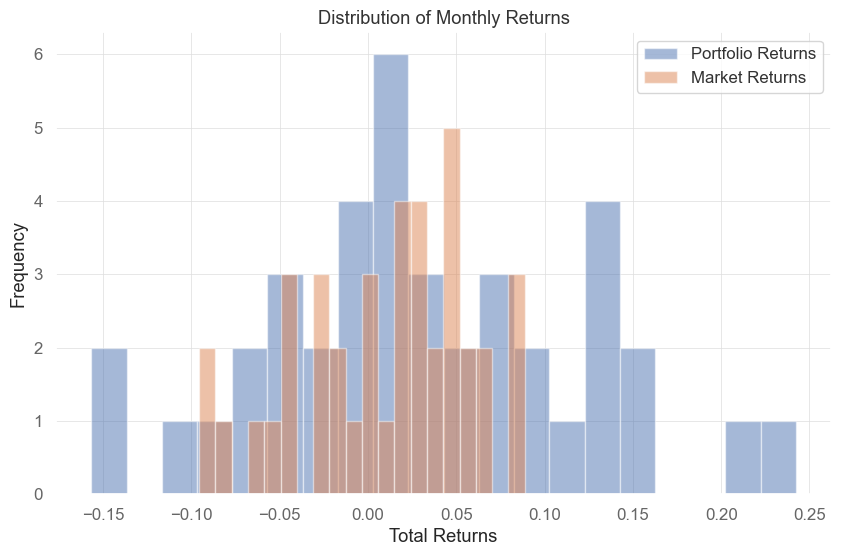

In [143]:
# Step 1: Calculate monthly total returns
portfolio_monthly_returns = return_portfolio.resample('M').sum().to_frame()
portfolio_monthly_returns.columns = ['Total_Returns_portfolio']

market_monthly_returns = return_market.resample('M').sum().to_frame()
market_monthly_returns.columns = ['Total_Returns_market']

# Step 2: Merge the two dataframes based on the month
merged_returns = pd.merge(portfolio_monthly_returns, market_monthly_returns, left_index=True, right_index=True)

# Step 3: Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(merged_returns['Total_Returns_portfolio'], bins=20, alpha=0.5, label='Portfolio Returns')
plt.hist(merged_returns['Total_Returns_market'], bins=20, alpha=0.5, label='Market Returns')
plt.title('Distribution of Monthly Returns')
plt.xlabel('Total Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()



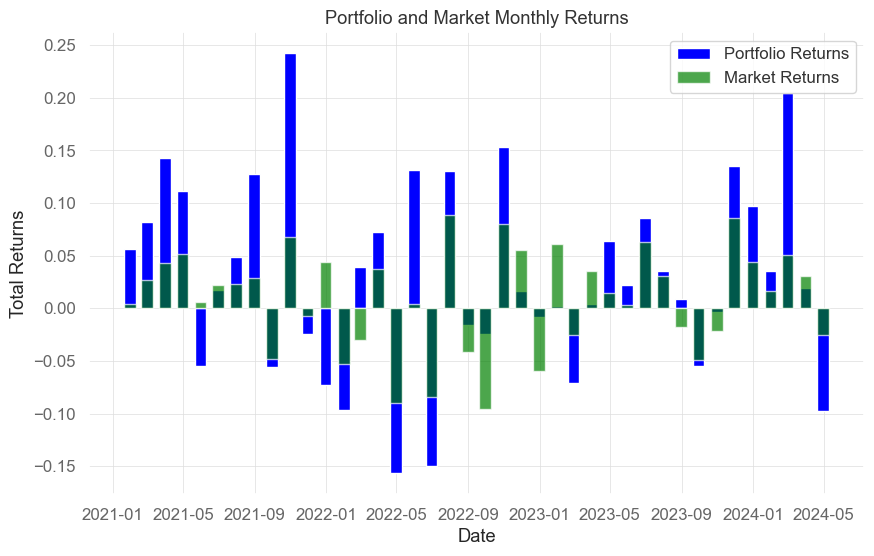

In [144]:
# Step 2: Plot portfolio and market monthly returns on the same graph
plt.figure(figsize=(10, 6))

# Plot portfolio monthly returns
plt.bar(merged_returns.index, merged_returns['Total_Returns_portfolio'], width=20, label='Portfolio Returns', color='blue')

# Plot market monthly returns with slight offset to avoid overlap
plt.bar(merged_returns.index, merged_returns['Total_Returns_market'], width=20, label='Market Returns', color='green', alpha=0.7)

plt.title('Portfolio and Market Monthly Returns')
plt.xlabel('Date')
plt.ylabel('Total Returns')
plt.legend()
plt.show()


## Risk measurements

In [145]:
def mean_return(returns, N=255):
    return returns.mean() * N

def calculate_std(returns):
    return np.std(returns)

def annualized_return(returns, N=255):
    return np.prod(returns + 1)**(N/len(returns)) - 1

def annualized_volatility(returns, N=255):
    return np.std(returns) * np.sqrt(N)

def calculate_var(returns, confidence_level=0.95):
    return np.percentile(returns, (1 - confidence_level) * 100)

def calculate_cvar(returns, confidence_level=0.95):
    var = calculate_var(returns, confidence_level)
    return returns[returns <= var].mean()

def sharpe_ratio(returns ,N=255,rf=0.01):
    mean = returns.mean() * N -rf
    sigma = returns.std() * np.sqrt(N)
    return mean / sigma

def sortino_ratio(returns ,N=255,rf=0.01):
    mean = returns.mean() * N -rf
    std_neg = returns[returns<0].std()*np.sqrt(N)
    return mean/std_neg

def maxDD(returns):
    comp_ret = (returns+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()

def calmars(returns, N=255):
    max_draw= maxDD(returns)
    calmars = returns.mean()*N/abs(max_draw)
    return calmars

def calculate_skewness(returns):
    return skew(returns)

def calculate_kurtosis(returns):
    return kurtosis(returns)


def probabilistic_sharpe_ratio(sharpe_ratio, benchmark_sharpe, n_samples):
    """
    Calculate the Probabilistic Sharpe Ratio.

    Parameters:
    sharpe_ratio (float): The Sharpe ratio of the portfolio.
    benchmark_sharpe (float): The benchmark Sharpe ratio to compare against.
    n_samples (int): The number of returns samples.

    Returns:
    float: The probabilistic Sharpe ratio.
    """
    
    # Calculate the Sharpe Ratio's expected value and standard deviation
    sr_mean = sharpe_ratio
    sr_std = (1 + 0.5 * sharpe_ratio**2) / np.sqrt(n_samples - 1)

    # Calculate the PSR
    psr = norm.cdf((sr_mean - benchmark_sharpe) / sr_std)
    return psr

In [158]:
return_portfolio = df_portfolio.pct_change().dropna()
return_market = market.pct_change().dropna()

# List of risk metric functions and their names
risk_functions = [
    ('Mean return', mean_return),
    ('Standard Deviation', calculate_std),
    ('Annualized return', annualized_return),
    ('Annualized volatility', annualized_volatility),
    ('VaR 95', calculate_var),
    ('CVaR 95', calculate_cvar),
    ('Sharpe ratio', sharpe_ratio),
    ('Sortino ratio', sortino_ratio),
    ('Maximun Drawdown', maxDD),
    ('Calmars ratio', calmars),
    ('Skewness', calculate_skewness),
    ('Kurtosis', calculate_kurtosis)
]

# Calculate risk values for portfolio and benchmark using a loop
portfolio_risk_values = []
benchmark_risk_values = []

for name, func in risk_functions:
    portfolio_risk_values.append(func(return_portfolio))
    benchmark_risk_values.append(func(return_market))

# Extract risk metric names from the risk_functions list
risk_metrics = [name for name, _ in risk_functions]

# Create DataFrame
data = {
    'Risk Metric': risk_metrics,
    'Portfolio': portfolio_risk_values,
    'Benchmark': benchmark_risk_values
}

df = pd.DataFrame(data)
print(df)

#Calculate Probabilistic Sharpe ratio
portfolio_sharpe= sharpe_ratio(return_portfolio)
market_sharpe = sharpe_ratio(return_market)
n_samples = len(return_portfolio)
PSR= probabilistic_sharpe_ratio(portfolio_sharpe, market_sharpe, n_samples)
print ('Probabilistic Sharpe ratio: ', PSR)
print('Total cost fee USD',round(sum(hapi),2))
print('% cost total investment', round(sum(hapi)/1_000 *100,2) )
print('Portfolio % return', round((df_portfolio[-1]-df_portfolio[0])/df_portfolio[0]*100,2))
print('S&P 500 % return', round((market[-1]-market[0])/market[0]*100,2))

              Risk Metric  Portfolio  Benchmark
0             Mean return   0.370433   0.115687
1      Standard Deviation   0.018367   0.010795
2       Annualized return   0.386944   0.106050
3   Annualized volatility   0.293291   0.172385
4                  VaR 95  -0.028727  -0.016967
5                 CVaR 95  -0.042142  -0.024628
6            Sharpe ratio   1.228192   0.612712
7           Sortino ratio   1.754669   0.879992
8        Maximun Drawdown  -0.316359  -0.254251
9           Calmars ratio   1.170925   0.455010
10               Skewness  -0.281093  -0.152898
11               Kurtosis   0.898797   1.757347
Probabilistic Sharpe ratio:  1.0
Total cost fee USD 14.1
% cost total investment 1.41
Portfolio % return 192.98
S&P 500 % return 38.45


# Fama Fench evaluation

In [147]:
# Get the Fama French 3 factor model (monthly data)
df_ff3_monthly = gff.famaFrench3Factor(frequency='m')
df_ff3_monthly

,date_ff_factors,Mkt-RF,SMB,HML,RF
0,1926-07-31,0.0296,-0.0256,-0.0243,0.0022
1,1926-08-31,0.0264,-0.0117,0.0382,0.0025
2,1926-09-30,0.0036,-0.0140,0.0013,0.0023
3,1926-10-31,-0.0324,-0.0009,0.0070,0.0032
4,1926-11-30,0.0253,-0.0010,-0.0051,0.0031
...,...,...,...,...,...
1168,2023-11-30,0.0884,-0.0002,0.0164,0.0044
1169,2023-12-31,0.0487,0.0634,0.0493,0.0043
1170,2024-01-31,0.0071,-0.0509,-0.0238,0.0047
1171,2024-02-29,0.0506,-0.0024,-0.0349,0.0042


In [148]:
# Convert date_ff_factors to datetime format
df_ff3_monthly['date_ff_factors'] = pd.to_datetime(df_ff3_monthly['date_ff_factors'])

# Set the date as the index
df_ff3_monthly.set_index('date_ff_factors', inplace=True)

# Resample to daily frequency
#df_ff3_daily = df_ff3_monthly.resample('D').asfreq()

# Forward-fill NaN values for daily frequency
#df_ff3_daily.fillna(method='ffill', inplace=True)

In [149]:
# Get the portfolio returns
portfolio_returns=pd.DataFrame(df_portfolio.pct_change())

In [150]:
fama_fench = portfolio_returns.merge(df_ff3_monthly, how='inner', left_index=True, right_index=True) # Join the Fama Fench factors with portfolio returns
fama_fench = fama_fench.dropna()
# Calculate excess return of portfolio
fama_fench['Excess Return'] = fama_fench[0] - fama_fench['RF']

In [151]:
fama_fench

,0,Mkt-RF,SMB,HML,RF,Excess Return
2021-03-31,0.024035,0.0308,-0.0237,0.0739,0.0000,0.024035
2021-04-30,0.005823,0.0493,-0.0319,-0.0095,0.0000,0.005823
2021-06-30,0.013093,0.0275,0.0168,-0.0787,0.0000,0.013093
2021-08-31,0.014006,0.0291,-0.0042,-0.0015,0.0000,0.014006
2021-09-30,0.001722,-0.0437,0.0071,0.0508,0.0000,0.001722
2021-11-30,-0.011869,-0.0155,-0.0132,-0.0045,0.0000,-0.011869
2021-12-31,-0.006535,0.0310,-0.0167,0.0326,0.0001,-0.006635
2022-01-31,0.035188,-0.0625,-0.0594,0.1275,0.0000,0.035188
2022-02-28,0.027973,-0.0229,0.0219,0.0308,0.0000,0.027973
2022-03-31,-0.030350,0.0305,-0.0161,-0.0181,0.0001,-0.030450


In [152]:
# Define the independent variables (adding a constant for the intercept)
X = fama_fench[['Mkt-RF', 'SMB', 'HML']]
X = sm.add_constant(X)

# Define the dependent variable
y = fama_fench['Excess Return']

# Perform the regression analysis
model = sm.OLS(y, X).fit()

# Display the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess Return   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.8754
Date:                Sat, 18 May 2024   Prob (F-statistic):              0.468
Time:                        20:18:11   Log-Likelihood:                 74.690
No. Observations:                  27   AIC:                            -141.4
Df Residuals:                      23   BIC:                            -136.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.003     -0.540      0.5

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2021-01-06   2021-01-06
End Period                 2024-05-03   2024-05-03
Risk-Free Rate             0.0%         0.0%
Time in Market             12.0%        100.0%

Cumulative Return          -100.0%      186.44%
CAGR﹪                     -100.0%      24.44%

Sharpe                     -0.48        1.23
Prob. Sharpe Ratio         6.32%        98.69%
Smart Sharpe               -0.48        1.23
Sortino                    -0.48        1.79
Smart Sortino              -0.48        1.79
Sortino/√2                 -0.34        1.27
Smart Sortino/√2           -0.34        1.27
Omega                      1.23         1.23

Max Drawdown               -100.0%      -31.64%
Longest DD Days            1090         610
Volatility (ann.)          55.11%       29.17%
R^2                        0.0          0.0
Information Ratio          0.06         0.06
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-11-09,2022-06-23,2023-07-11,610,-31.635920,-29.490419
2,2021-05-12,2021-07-19,2021-08-10,91,-19.338921,-18.687460
3,2024-03-05,2024-05-01,2024-05-03,60,-14.376866,-14.122712
4,2021-02-22,2021-02-25,2021-03-10,17,-12.164367,-11.751534
5,2021-09-03,2021-09-21,2021-10-13,41,-10.210585,-9.716488


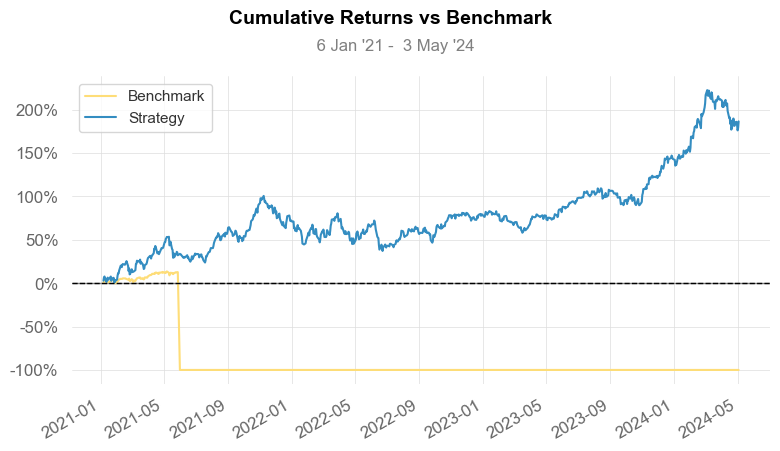

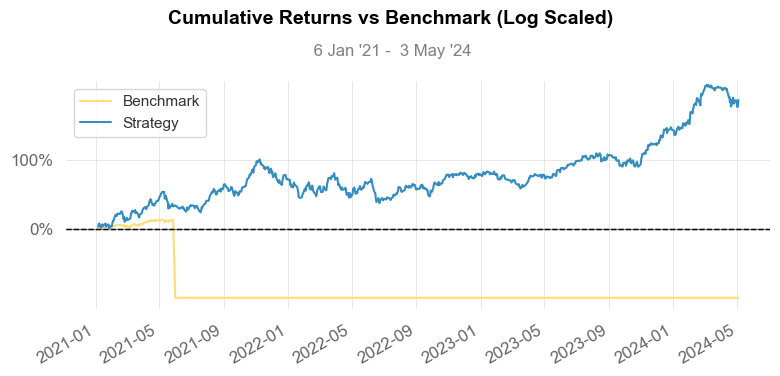

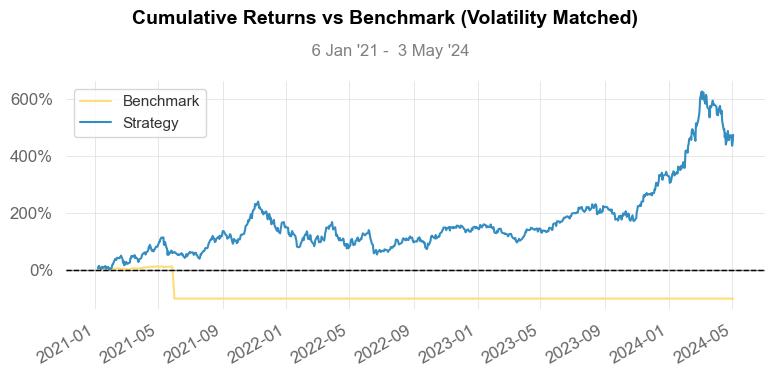

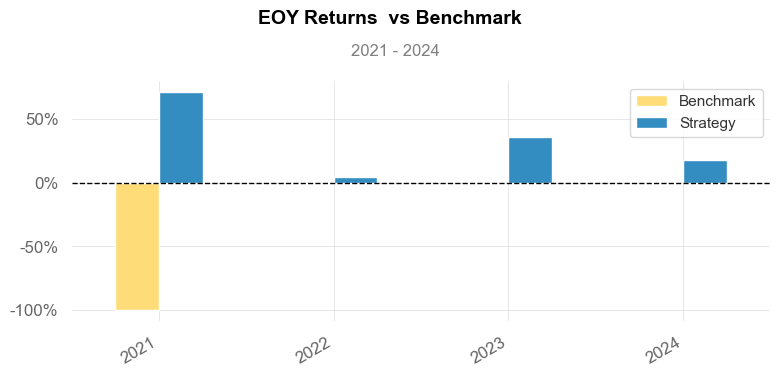

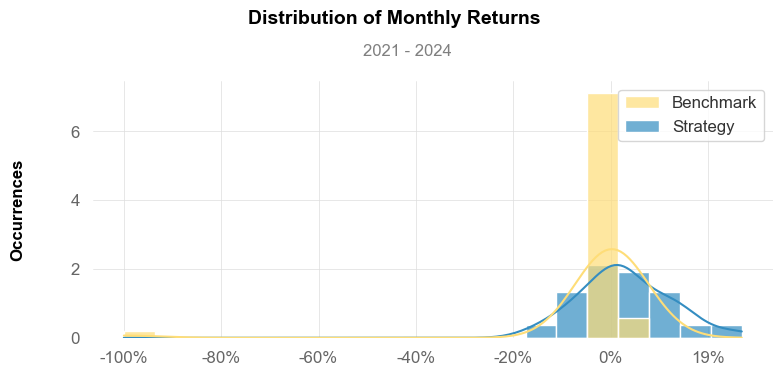

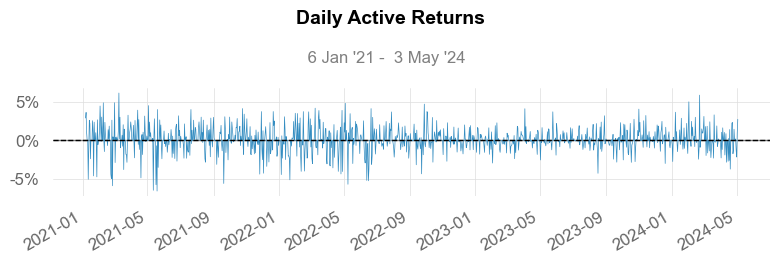

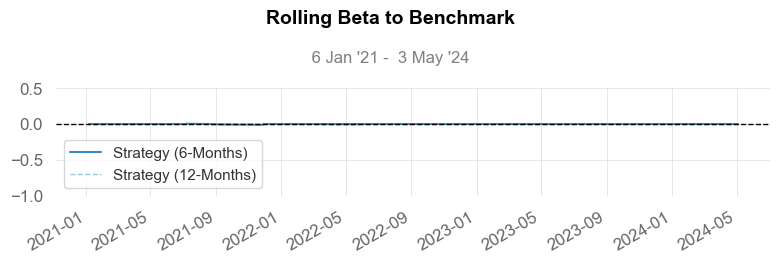

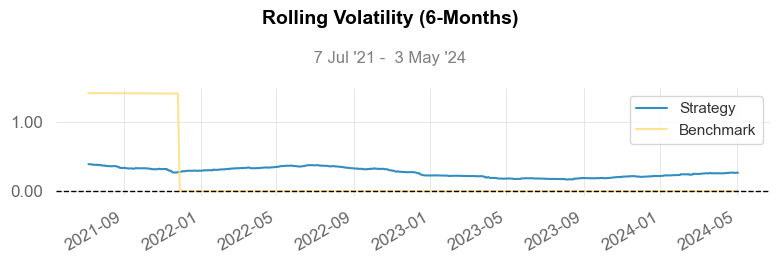

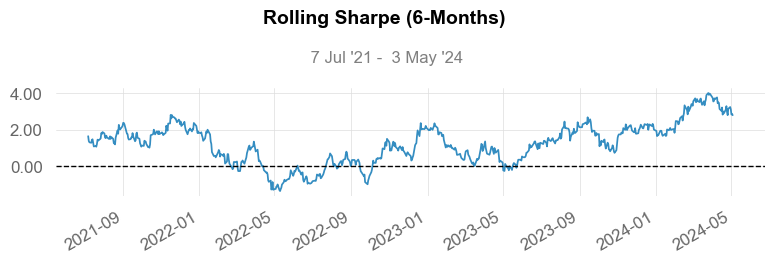

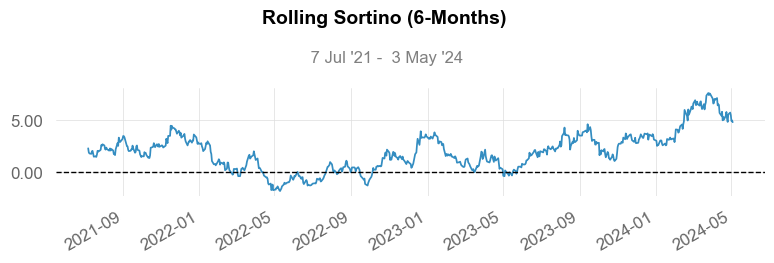

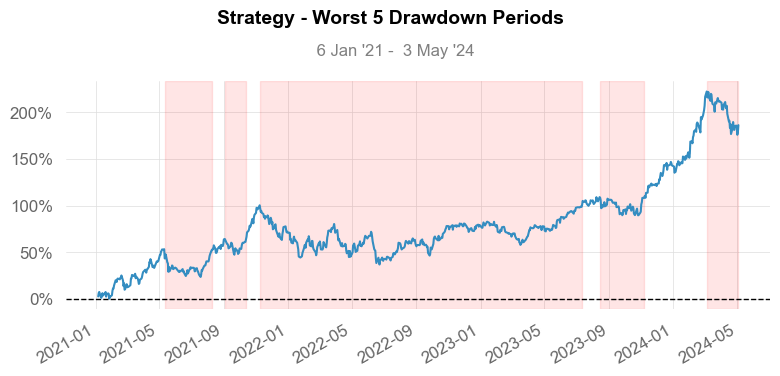

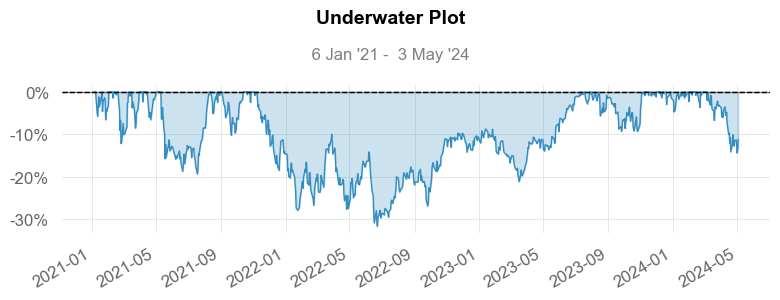

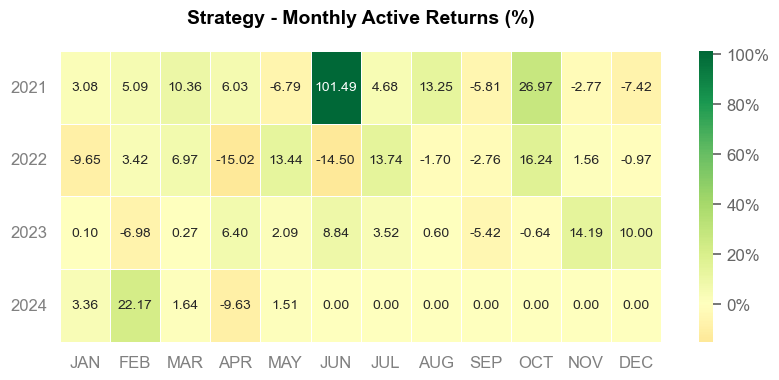

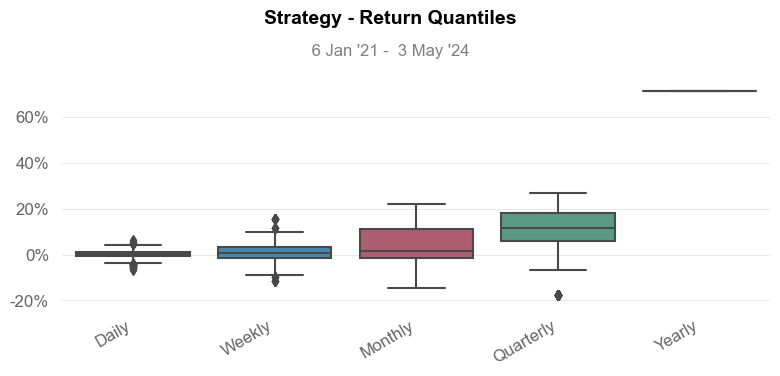

In [153]:
qs.reports.full(df_portfolio, benchmark = market)

In [154]:
merged_returns.describe()

,Total_Returns_portfolio,Total_Returns_market
count,40.000000,40.000000
mean,0.030044,0.009334
std,0.090667,0.048636
min,-0.156595,-0.095551
25%,-0.024613,-0.025063
50%,0.020753,0.019267
75%,0.088529,0.043743
max,0.242337,0.088779
